# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lasio

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage  

import pandas as pd

# Supprt functions

In [2]:
def ismember(A, B):
    return [ np.sum(a == B) for a in A ]

# Loading las file

In [12]:
dataFolderName = "las_files"
lasFileName    = "2F19_08-_1_jwl_JWL_FILE_243939324.las"
fullFileName = dataFolderName + '/' + lasFileName
las = lasio.read(fullFileName);
las.keys()

['DEPTH',
 'DTC',
 'DTS',
 'GR',
 'K',
 'KTH',
 'RD',
 'RM',
 'RS',
 'RTHK',
 'RTHU',
 'RUK',
 'TH',
 'UR']

In [13]:
selectedLogsName = ['GR', 'DTC', 'DTS', 'RD']
minDepth     =  0
maxDepth     =  10000
nullValue    = -999.2500 

depth = las['DEPTH'];
selectedDepth = np.logical_and(depth >= minDepth, depth <= maxDepth);

selectedLogs = np.array([1 if head in selectedLogsName else 0 for head in las.keys()])
selectedLogsIx = np.array([ind for ind, head in enumerate(las.keys()) if head in selectedLogsName])
selectedLogsIx

# Remove nans
selectedData = las.data
selectedData = las.data[:, selectedLogsIx]


indNotNan = ~np.isnan(selectedData).any(axis=1)
selectedData = selectedData[indNotNan];
depth = depth[indNotNan]; 

normalizedData = normalize(selectedData, axis = 0)

# Some statistics
nLogs = len(selectedLogsName)
nFacies = 5
nPoints = normalizedData.shape[0]


# Analysis

In [14]:
# PCA
dataToAnalyze = normalizedData

pca = PCA(n_components=2).fit_transform(normalizedData)
#print(pca.explained_variance_ratio_)

kmeans = KMeans(init='k-means++', n_clusters=nFacies, n_init=10);
kmeans.fit(pca)
labels = kmeans.predict(pca)

# Plotting

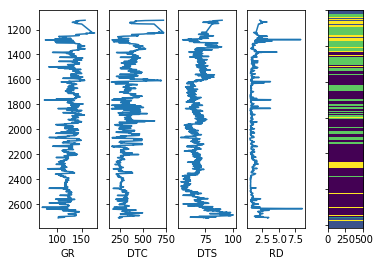

In [15]:
# Some plotting

imageToShow = np.tile(labels, (500, 1)).T

fig = plt.figure()

for index in range(nLogs):
    plt.subplot(1, nLogs+1, index+1)
    ax = plt.plot(selectedData[:,index], depth)
    plt.gca().invert_yaxis()
    plt.xlabel(selectedLogsName[index])
    if(index>0):
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            labelright =False,      # ticks along the bottom edge are off
            labelleft =False,         # ticks along the top edge are off
            ) 

axResult = plt.subplot(1, nLogs+1, nLogs+1)
plt.imshow(imageToShow);
#plt.gca().invert_yaxis()
plt.tick_params(
    axis='both',            # changes apply to the x-axis
    which='both',           # both major and minor ticks are affected
    labelright =False,      # ticks along the bottom edge are off
    labelleft =False,       # ticks along the top edge are off
    ) 

# Upscaling

In [8]:
# Get tables of facies properties

meanTable = np.zeros([nFacies,nLogs])
varTable = np.zeros([nFacies,nLogs])

for faciesInd in range(nFacies):
    for logInd in range(nLogs):
        selectedDataInd = labels == faciesInd
        meanTable[faciesInd, logInd] = np.mean(selectedData[selectedDataInd,logInd])
        varTable[faciesInd, logInd] = np.var(selectedData[selectedDataInd,logInd])
        

meanTablePD = pd.DataFrame(meanTable, columns = selectedLogsName) 
varTablePD = pd.DataFrame(varTable, columns = selectedLogsName)  

print("Mean Summary Table")
print(meanTablePD)

print("Variance Summary Table")
print(varTablePD)

Mean Summary Table
           GR         DTC        DTS         K        RD
0  121.863411  283.797634  64.599438  4.604298  0.887095
1  127.350580  344.107751  79.380704  4.619245  2.536459
2  141.165114  432.510019  70.366656  4.788193  0.915334
3  110.558273  221.149273  72.636364  4.555455  7.028845
4  120.637372  296.658603  69.812540  4.603130  1.546562
Variance Summary Table
           GR          DTC         DTS         K        RD
0  116.887959  1906.969001   25.990960  0.088004  0.023316
1  232.226401  9462.623505  112.292819  0.086516  0.262869
2   65.624342  4449.651917   29.025089  0.086678  0.040484
3  264.791627  1033.066062   95.045375  0.117565  1.441799
4  182.195319  4332.787528   44.925412  0.086717  0.048742


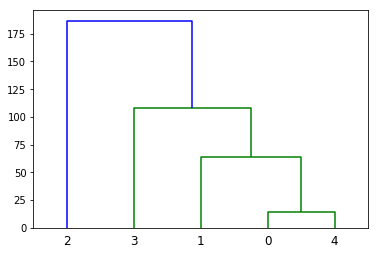

In [9]:
linked = linkage(meanTablePD, 'ward')
dendrogram(linked,  
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [10]:
upscalingMatrix = np.zeros([nPoints, nFacies])
upscalingMatrix[:,0] = labels;

for upscaleInd in range(0,nFacies-1):
    left  = linked[upscaleInd,0];
    right = linked[upscaleInd,1];
    newLables   =  np.copy(upscalingMatrix[:,upscaleInd])
    nLeft  = np.sum(upscaleInd == left)
    nRight = np.sum(upscaleInd == right)
    
    if (nLeft > nRight):
        newLables[newLables == right] = left
        linked[linked == (nFacies+upscaleInd)]= left
    else:
        newLables[newLables == left] = right
        linked[linked == (nFacies+upscaleInd)]= right
        
    upscalingMatrix[:,upscaleInd+1] = newLables


C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


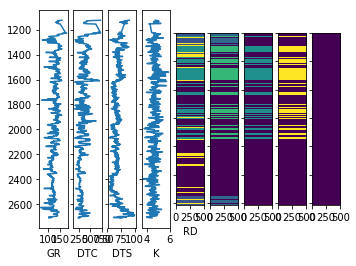

In [11]:
# Some plotting

fig = plt.figure()

for index in range(nLogs):
    plt.subplot(1, nLogs+nFacies, index+1)
    ax = plt.plot(selectedData[:,index], depth)
    plt.gca().invert_yaxis()
    plt.xlabel(selectedLogsName[index])
    if(index>0):
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            labelright =False,      # ticks along the bottom edge are off
            labelleft =False,         # ticks along the top edge are off
            ) 

        
for index in range(nFacies):
    labelsToUse = upscalingMatrix[:,index]
    imageToShow = np.tile(labelsToUse, (500, 1)).T
    axResult = plt.subplot(1, nLogs+nFacies, nLogs+index)
    
    plt.imshow(imageToShow);
    #plt.gca().invert_yaxis()
    plt.tick_params(
        axis='both',            # changes apply to the x-axis
        which='both',           # both major and minor ticks are affected
        labelright =False,      # ticks along the bottom edge are off
        labelleft =False,       # ticks along the top edge are off
        ) 